In [1]:
import torch
import numpy as np
import sklearn

from utils import *
from architectures import *
import preprocess

from CategoricalDiffusion import *
from denoiser import *

In [2]:
X_train, y_train, X_test, y_test = preprocess.main()

11608it [01:51, 103.92it/s]
100%|████████████████████████████████████████| 21/21 [00:00<00:00, 10540.97it/s]


In [3]:
protein_dataset = ProteinDataset(seq_data=X_train, include_mask=True)
protein_loader = torch.utils.data.DataLoader(protein_dataset, batch_size=32, shuffle=True)
for batch in protein_loader:
    X, Y = batch
    X_seq = X['seq']
    Y_seq = Y['seq']
    break

In [4]:
noise_matrix = Noiser(noiser = 'BERT-LIKE', beta_t = 0.01).noise_matrix
ts, noised_samples = noiser(X_seq, noise_matrix, 100, X_seq.shape[-1])

In [5]:
denoiser = Denoiser(8,1,128,X_seq.shape[2])

In [6]:
cat_diff = CategoricalDiffusion(denoiser, noise_matrix)

In [12]:
cat_diff.decode(noised_samples, ts)

In [30]:
X_seq == Y_seq

tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]],

        [[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]],

        [[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]],

In [33]:
cat_diff.y_pred = Y_seq.tile(100,1,1,1) + 1e-6

In [34]:
cat_diff.recon_loss(Y_seq.tile(100,1,1,1))

tensor(-0.1783)

In [13]:
cat_diff.y_pred

tensor([[[[0.0663, 0.0498, 0.0347,  ..., 0.0881, 0.0347, 0.0347],
          [0.0681, 0.0517, 0.0350,  ..., 0.0869, 0.0350, 0.0350],
          [0.0626, 0.0471, 0.0352,  ..., 0.0896, 0.0352, 0.0352],
          ...,
          [0.0628, 0.0507, 0.0348,  ..., 0.0894, 0.0348, 0.0348],
          [0.0645, 0.0488, 0.0352,  ..., 0.0899, 0.0352, 0.0352],
          [0.0656, 0.0491, 0.0347,  ..., 0.0872, 0.0347, 0.0347]],

         [[0.0630, 0.0559, 0.0348,  ..., 0.0872, 0.0348, 0.0348],
          [0.0675, 0.0501, 0.0349,  ..., 0.0875, 0.0349, 0.0349],
          [0.0666, 0.0484, 0.0350,  ..., 0.0876, 0.0350, 0.0350],
          ...,
          [0.0674, 0.0524, 0.0351,  ..., 0.0812, 0.0351, 0.0351],
          [0.0648, 0.0494, 0.0350,  ..., 0.0823, 0.0350, 0.0350],
          [0.0682, 0.0495, 0.0353,  ..., 0.0856, 0.0353, 0.0353]],

         [[0.0670, 0.0486, 0.0353,  ..., 0.0889, 0.0353, 0.0353],
          [0.0634, 0.0499, 0.0351,  ..., 0.0943, 0.0351, 0.0351],
          [0.0662, 0.0479, 0.0346,  ..., 0

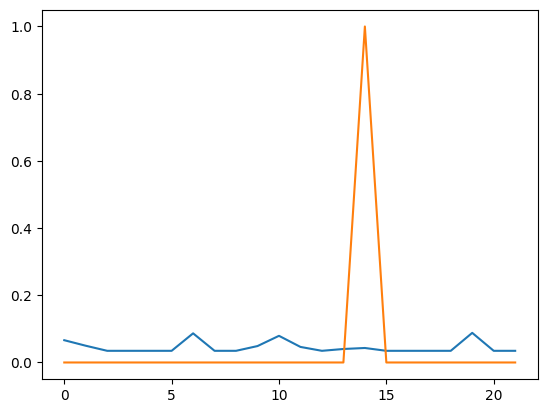

In [25]:
import matplotlib.pyplot as plt

plt.plot(cat_diff.y_pred.detach().numpy()[0][0][0])
plt.plot(noised_samples[0][0][0])

In [9]:
cat_diff.recon_loss(noised_samples)

tensor(581508.8125, grad_fn=<NegBackward0>)

In [10]:
cat_diff.L_T(noised_samples)

tensor(323531.6250)

In [38]:
cat_diff.denoiser.forward_time_1(ts)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (100x32 and 1x128)

In [11]:
from tqdm import tqdm
epochs = 100

cat_diff.train()
optim = torch.optim.Adam(cat_diff.parameters(), lr = 1e-3)

for epoch in range(epochs):
    overall_loss = 0
    protein_loader = torch.utils.data.DataLoader(protein_dataset, batch_size=32, shuffle=True)
    for batch in tqdm(protein_loader):
        X, Y = batch
        
        X_seq = X['seq']
        Y_seq = Y['seq']
        
        ts, noised_samples = noiser(X_seq, noise_matrix, 100, X_seq.shape[-1])

        cat_diff.decode(noised_samples, ts)
        
        LT_loss     = cat_diff.L_T(noised_samples)
        print(LT_loss)

        recon_loss  = cat_diff.recon_loss(noised_samples)
        print(recon_loss)

        
        
        #Lt0_t1_loss = cat_diff.L_t0t1(Y_seq)
        #print(Lt0_t1_loss.item())

        #Ltminus1    = cat_diff.L_tminus1(Y_seq, noised_samples)
        #print(Ltminus1.item())

        loss = LT_loss + recon_loss
        print(loss.item())
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        overall_loss += loss.item()
    print('overall loss at epoch {} is '.format(epoch) + str(overall_loss/X_train.shape[0]))

  0%|                                                   | 0/246 [00:00<?, ?it/s]

tensor(330757.0938)
tensor(580931.7500, grad_fn=<NegBackward0>)
911688.875


  0%|▏                                        | 1/246 [00:48<3:19:25, 48.84s/it]

tensor(327054.5938)
tensor(575279.0625, grad_fn=<NegBackward0>)
902333.625


  1%|▎                                        | 2/246 [01:25<2:49:53, 41.78s/it]

tensor(329693.3750)
tensor(570915.1250, grad_fn=<NegBackward0>)
900608.5


  1%|▌                                        | 3/246 [02:04<2:43:45, 40.44s/it]

tensor(322592.1562)
tensor(569689.1875, grad_fn=<NegBackward0>)
892281.375


  2%|▋                                        | 4/246 [02:43<2:40:22, 39.76s/it]

tensor(322136.2812)
tensor(572581.4375, grad_fn=<NegBackward0>)
894717.75


  2%|▊                                        | 5/246 [03:22<2:39:34, 39.73s/it]

tensor(326073.6875)
tensor(571429.5000, grad_fn=<NegBackward0>)
897503.1875


  2%|█                                        | 6/246 [03:59<2:34:15, 38.57s/it]

tensor(319331.6875)
tensor(570615.1250, grad_fn=<NegBackward0>)
889946.8125


  3%|█▏                                       | 7/246 [04:46<2:44:45, 41.36s/it]

tensor(332497.8750)
tensor(572171.8125, grad_fn=<NegBackward0>)
904669.6875


  3%|█▎                                       | 8/246 [05:26<2:42:44, 41.03s/it]

tensor(327524.3438)
tensor(568877.4375, grad_fn=<NegBackward0>)
896401.75


  4%|█▌                                       | 9/246 [06:02<2:35:52, 39.46s/it]

tensor(322633.6250)
tensor(565177.5000, grad_fn=<NegBackward0>)
887811.125


  4%|█▋                                      | 10/246 [06:42<2:35:48, 39.61s/it]

tensor(322288.2188)
tensor(568001.3125, grad_fn=<NegBackward0>)
890289.5


  4%|█▊                                      | 11/246 [07:22<2:35:37, 39.73s/it]

tensor(332166.3438)
tensor(567990., grad_fn=<NegBackward0>)
900156.375


  5%|█▉                                      | 12/246 [07:58<2:30:17, 38.53s/it]

tensor(327096.0625)
tensor(567166., grad_fn=<NegBackward0>)
894262.0625


  5%|██                                      | 13/246 [08:36<2:29:09, 38.41s/it]

tensor(335772.1875)
tensor(569685.8750, grad_fn=<NegBackward0>)
905458.0625


  6%|██▎                                     | 14/246 [09:18<2:32:22, 39.41s/it]

tensor(324802.6250)
tensor(566062.1875, grad_fn=<NegBackward0>)
890864.8125


  6%|██▍                                     | 15/246 [09:57<2:31:09, 39.26s/it]

tensor(324899.3750)
tensor(570312.8750, grad_fn=<NegBackward0>)
895212.25


  7%|██▌                                     | 16/246 [10:35<2:29:19, 38.96s/it]

tensor(322454.0312)
tensor(568489.7500, grad_fn=<NegBackward0>)
890943.75


  7%|██▊                                     | 17/246 [11:13<2:27:28, 38.64s/it]

tensor(325603.9375)
tensor(566207.6875, grad_fn=<NegBackward0>)
891811.625


  7%|██▉                                     | 18/246 [11:53<2:28:49, 39.17s/it]

tensor(324705.9375)
tensor(566745., grad_fn=<NegBackward0>)
891450.9375


  8%|███                                     | 19/246 [12:34<2:29:50, 39.60s/it]

tensor(327413.7812)
tensor(570738.4375, grad_fn=<NegBackward0>)
898152.25


  8%|███▎                                    | 20/246 [13:11<2:26:57, 39.02s/it]

tensor(327413.7812)
tensor(567942.7500, grad_fn=<NegBackward0>)
895356.5


  9%|███▍                                    | 21/246 [13:51<2:26:46, 39.14s/it]

tensor(325382.9062)
tensor(567929.5625, grad_fn=<NegBackward0>)
893312.5


  9%|███▌                                    | 22/246 [14:29<2:25:12, 38.89s/it]

tensor(324636.8438)
tensor(568061., grad_fn=<NegBackward0>)
892697.875


  9%|███▋                                    | 23/246 [15:09<2:25:25, 39.13s/it]

tensor(329707.1875)
tensor(569055.3750, grad_fn=<NegBackward0>)
898762.5625


 10%|███▉                                    | 24/246 [15:53<2:29:49, 40.49s/it]

tensor(322854.6875)
tensor(568472.1250, grad_fn=<NegBackward0>)
891326.8125


 10%|████                                    | 25/246 [16:33<2:28:54, 40.43s/it]

tensor(325065.1250)
tensor(569316.6250, grad_fn=<NegBackward0>)
894381.75


 11%|████▏                                   | 26/246 [17:15<2:30:12, 40.97s/it]

tensor(333824.1875)
tensor(564705.5000, grad_fn=<NegBackward0>)
898529.6875


 11%|████▍                                   | 27/246 [17:52<2:24:51, 39.69s/it]

tensor(322509.2812)
tensor(567058.6875, grad_fn=<NegBackward0>)
889568.0


 11%|████▌                                   | 28/246 [18:29<2:21:23, 38.92s/it]

tensor(322757.9375)
tensor(568386.1250, grad_fn=<NegBackward0>)
891144.0625


 12%|████▋                                   | 29/246 [19:09<2:22:28, 39.39s/it]

tensor(322716.5312)
tensor(569810.0625, grad_fn=<NegBackward0>)
892526.625


 12%|████▉                                   | 30/246 [19:52<2:25:21, 40.38s/it]

tensor(327441.4062)
tensor(564433.2500, grad_fn=<NegBackward0>)
891874.625


 13%|█████                                   | 31/246 [20:34<2:26:12, 40.80s/it]

tensor(319511.3125)
tensor(568206.8750, grad_fn=<NegBackward0>)
887718.1875


 13%|█████                                   | 31/246 [21:14<2:27:19, 41.11s/it]


KeyboardInterrupt: 

In [8]:
denoiser.eval()

Denoiser(
  (activation): ReLU()
  (forward_time_1): FeedForward(
    (layer): Linear(in_features=1, out_features=128, bias=True)
    (activation): ReLU()
  )
  (forward_time_2): FeedForward(
    (layer): Linear(in_features=128, out_features=128, bias=True)
    (activation): ReLU()
  )
  (forward_time_3): FeedForward(
    (layer): Linear(in_features=128, out_features=128, bias=True)
    (activation): ReLU()
  )
  (forward_seq_1): FeedForward(
    (layer): Linear(in_features=22, out_features=128, bias=True)
    (activation): ReLU()
  )
  (forward_seq_2): FeedForward(
    (layer): Linear(in_features=128, out_features=128, bias=True)
    (activation): ReLU()
  )
  (forward_seq_3): FeedForward(
    (layer): Linear(in_features=128, out_features=128, bias=True)
    (activation): ReLU()
  )
  (forward_time_seq): FeedForward(
    (layer): Linear(in_features=256, out_features=128, bias=True)
    (activation): ReLU()
  )
  (mha_1): MultiHeadedAttention(
    (attention): Attention()
    (W_q): Li

In [9]:
noised_samples.shape

torch.Size([100, 32, 59, 22])

In [10]:
y_pred = denoiser(noised_samples, ts)

In [11]:
y_pred.shape

torch.Size([100, 32, 59, 22])

In [12]:
y_pred[1][0:2]

tensor([[[0.0496, 0.0415, 0.0415,  ..., 0.0426, 0.0496, 0.0442],
         [0.0496, 0.0415, 0.0415,  ..., 0.0426, 0.0496, 0.0442],
         [0.0521, 0.0417, 0.0417,  ..., 0.0433, 0.0491, 0.0428],
         ...,
         [0.0508, 0.0415, 0.0415,  ..., 0.0430, 0.0490, 0.0434],
         [0.0508, 0.0416, 0.0416,  ..., 0.0449, 0.0484, 0.0417],
         [0.0521, 0.0417, 0.0417,  ..., 0.0433, 0.0491, 0.0428]],

        [[0.0517, 0.0416, 0.0416,  ..., 0.0431, 0.0488, 0.0429],
         [0.0509, 0.0415, 0.0415,  ..., 0.0442, 0.0486, 0.0437],
         [0.0496, 0.0415, 0.0415,  ..., 0.0426, 0.0495, 0.0441],
         ...,
         [0.0508, 0.0416, 0.0416,  ..., 0.0449, 0.0483, 0.0416],
         [0.0508, 0.0415, 0.0415,  ..., 0.0440, 0.0483, 0.0440],
         [0.0521, 0.0417, 0.0417,  ..., 0.0438, 0.0483, 0.0423]]],
       grad_fn=<SliceBackward0>)

In [46]:
cat_diff = CategoricalDiffusion(denoiser, noise_matrix)

In [47]:
cat_diff.L_T(noised_samples, noise_matrix)

tensor(325148.0625)

In [48]:
cat_diff.L_t0t1(X_seq[0:2],ts[:,0:2], noised_samples[:,0:2,:,:])

tensor(364.4633, grad_fn=<NegBackward0>)

In [49]:
cat_diff.L_tminus1(X_seq, ts, noised_samples)

torch.Size([100, 32, 59, 22])


tensor(720177.4375, grad_fn=<SumBackward0>)

In [52]:
for parameter in cat_diff.parameters():
    print(parameter)

Parameter containing:
tensor([[-0.6056],
        [ 0.0624],
        [-0.3412],
        [ 0.7145],
        [-0.7960],
        [-0.8140],
        [ 0.4435],
        [ 0.3451],
        [-0.4423],
        [-0.3507],
        [-0.2473],
        [-0.8043],
        [ 0.1912],
        [-0.2725],
        [ 0.1511],
        [-0.0134],
        [-0.9085],
        [ 0.3196],
        [ 0.2804],
        [ 0.3093],
        [ 0.0128],
        [-0.3858],
        [-0.2689],
        [ 0.9807],
        [ 0.8842],
        [ 0.4777],
        [-0.6349],
        [ 0.8628],
        [ 0.2409],
        [-0.7710],
        [-0.1586],
        [-0.4698],
        [-0.5189],
        [ 0.5831],
        [-0.3778],
        [ 0.0260],
        [ 0.1287],
        [-0.8608],
        [-0.3708],
        [ 0.7822],
        [-0.0850],
        [ 0.0196],
        [ 0.2723],
        [ 0.0415],
        [-0.3743],
        [ 0.2874],
        [-0.9886],
        [ 0.1126],
        [ 0.1173],
        [-0.5255],
        [ 0.2560],
        [

In [98]:
noised_samples.shape

torch.Size([100, 32, 59, 22])

In [102]:
y_pred_reshaped = y_pred.view(noised_samples.shape)

In [120]:
(y_pred_reshaped[2][0] == y_pred[64]).all()

tensor(True)

In [123]:
(noised_samples[2][0]==noised_samples_reshaped[64]).all()

tensor(True)

In [125]:
new_test = y_pred_reshaped[2]

In [129]:
(new_test * noised_samples[0])

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0409, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0415, 0.0000, 0.

In [94]:
test[test>0]

tensor([1.0826, 1.2775, 0.1294, 1.0052, 0.5819, 0.8000, 0.4890, 0.0455])

In [58]:
torch.matmul(x0,noise_matrix.matrix_power(3))

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0297],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0297],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0297],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0297],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0297],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0297]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0297],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0297],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0297],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0297],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0297],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0297]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.9703, 0.0000, 0.0297],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0297],
         [0.0000, 0.0000, 0.0000,  ..., 0.9703, 0.0000, 0.

In [39]:
reverse_marginals = torch.zeros(noised_samples.shape[0]-2, noised_samples.shape[1], noised_samples.shape[2], noised_samples.shape[3])

In [41]:
for t in range(2, noised_samples.shape[0]):
    xt = noised_samples[t]
    x0 = noised_samples[0]

    numer = torch.matmul(xt, noise_matrix.t()) * torch.matmul(x0, noise_matrix.matrix_power(t-1))
    denom = torch.matmul(torch.matmul(x0, noise_matrix.matrix_power(t)), xt.permute(0,2,1))
    denom = torch.diagonal(denom, dim1=-2, dim2=-1).unsqueeze(-1)
    reverse_marginals[t-2] = numer/denom

In [63]:
noised_samples[3][0][0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1.])

In [86]:
test = reverse_marginals[1]

In [87]:
test

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.6700],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 0.

In [69]:
test.shape

torch.Size([32, 59, 22])

In [73]:
other_test = test * torch.matmul(noised_samples[0], noise_matrix.matrix_power(3))

In [78]:
other_test[0]

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0239],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

In [28]:
ts[1].unsqueeze(1).shape

torch.Size([32, 1])

In [30]:
noised_samples[1].shape

torch.Size([32, 59, 22])

In [38]:
torch.matmul(noised_samples, noise_matrix.t()) * torch.matmul(

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.9900, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0

In [21]:
L_T(noised_samples_reshaped, noise_matrix)

tensor(325811.2188)

In [ ]:
class CategoricalDiffusion(torch.nn.Module):
    def __init__(
        denoiser
        
    ):
        super().__init__(**kwargs)
        self.denoiser = denoiser

    def denoising_process(self, noised_sample, ts):
        y_pred = self.denoiser(noised_sample)
        return y_pred

    def L_T(self, noised_sample, noise_matrix):
        vals, vecs = torch.linalg.eig(noise_matrix.t())
        vals = torch.real(vals)
        vecs = torch.real(vecs)

        PxT = vecs[:, torch.argmax(vals)].unsqueeze(0).unsqueeze(1)

        no_zeros_PxT = PxT + 1e-6
        no_zeros_X   = noised_sample + 1e-6
        
        dkl_steady_state = torch.sum(
            no_zeros_X * torch.log(no_zeros_X/no_zeros_PxT)
        )

        return dkl_steady_state

    def L_tminus1(self, real, noise, forward_step):
        fake = self.denoising_process(noise)
        output = real*fake
        qxtminus1_giv_xt_xtilde = reverse_marginal(noise_matrix, forward_step, reverse_step, output, noise)
        qxtminus1_xt_giv_xtilde = qxtminus1_giv_xt_xtilde * noise_matrix.matrix_power(forward_step)


    def L_t1(self, real, fake):
        """
        
        """
        return torch.sum(real * torch.log(fake+1e-6))
        